In [187]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

Last time, we failed to achieve compression due to a poor cost function. Instead of trying different cost functions, we will try to add many new wave features but still use linear regression. 

In [188]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
targetimage = train_X[1]

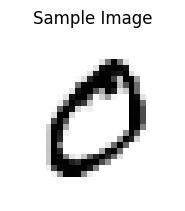

In [189]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Sample Image")
plt.show()

In [190]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

targetimage = feature_scale(targetimage, scaled=True)

In [191]:
targetimage = targetimage.flatten().astype(np.float64)
pixels = len(targetimage)
xcoordinates = np.linspace(0, 1, pixels).astype(np.float64).reshape((-1, 1))

Now $ f(x)=A\sin(Bx+C) $ is a single sample and we want the linear regression model to control as much as possible of this function. Now, from previous labs, it's clear that the model can only learn the parameter $A$. If we compute sin with custom $B$ and $C$, then the model can properly figure out $A$ parameter. The big question is how to choose $B$ and $C$ such that the model can use these new features effectively. As always, we first try to simplify the function as much as possible. It turns out, we can fully remove the phase parameter $C$ from the equation and add two features instead which simulate it. For this, we will use the sum trig identity to simplify this function. We firstly have $ \sin(a+b) = \sin(a)\cos(b)+\cos(a)\sin(b)$. If we apply this identity to the above function we have, then we get $ A\sin(Bx+C) = A\sin(Bx)\cos(C)+A\cos(Bx)\sin(C) $. Here, the $\cos(C)$ and $\sin(C)$ are just constants since they don't depend on the $x$ value. Therefore, we allow the model to learn these parameters separately and we get our new function as $ f(x)=A\sin(Bx) + D\cos(Bx) $. This fully removes the $C$ parameter and replaces it with 2 separate functions which we can replace as features separately. However, the $B$ parameter is still a problem. From here, the best way to choose the $B$ is to choose multiple $B$ values which represent different frequencies of the sine wave. If we use $N$ samples, We can choose $N$ different frequencies. Of course, we assume the data has infinite samples and not just a finite $N$ samples. However, in practice, it's good enough to have enough samples to represent the data accurately and more samples leads to marginally lower errors. This is possible because you only need few samples to represent the full data. Few samples with specific frequencies will be more useful to the model compared to other frequencies. This should make sense as most images are periodic in nature and are surprisingly patterned. A standard way to choose these frequencies is to use the fourier series. 

Fourier series describes a way to write a periodic function into sum of simpler sinusoidal functions. There are many different forms of the series one can think about, but we will look at the sine-cosine form which is the most useful for our model. 
$$ s_{_N}(x) = C_0 + \sum_{n=1}^N \left( 
A_n \cos \left(2 \pi \tfrac{n}{P} x \right) + 
B_n \sin \left(2 \pi \tfrac{n}{P} x  \right) \right)$$
This is the equation from the wikipedia page. As you can observe, it's split into sine and cosine just like how we have it and the big $N$ defines the number of samples we would like to settle on. $P$ is the period of the function here. We could choose any period here but I choose 1. From this, the period becomes a hyperparameter of the model and is important to decide on early. Also, clearly the samples is also a hyperparameter. $C_0$ is the bias in the model and the $A_n$ and $B_n$ are the model parameters or the weights in the linear regression model. Given this, it's easy to compute different frequencies that could most likely be useful for our model. 

In [192]:
def feature_engineer_wave(features, samples, period=1):
    xcoordinates_wave = np.array(features)

    for i in range(samples):
        frequency = 2 * np.pi * (i+1) / period
        wavefeatures_sin = np.sin(frequency * features)
        wavefeatures_cos = np.cos(frequency * features)
        # compute sin and cos for all coordinates as a vector

        xcoordinates_wave = np.hstack([xcoordinates_wave, wavefeatures_sin, wavefeatures_cos]) 
        # join the 2 new features vectors to the feature matrix

    return xcoordinates_wave

Of course, this code can be vectorized further, but I wanted to show the proof of concept first. 

In [193]:
xcoordinates_wave = feature_engineer_wave(xcoordinates, 200)
print(xcoordinates_wave.shape)

(784, 401)


Since we have $200$ samples, we have $2x$ features where each sample corresponds to sine or cosine. Now, we just use linear regression from scikit to fit the image. 

In [194]:
reg = LinearRegression().fit(xcoordinates_wave, targetimage)
predicted_image = reg.predict(xcoordinates_wave)
print(reg.coef_.shape)

(401,)


As expected, the number of weights is also around ~$400$. This is smaller than $28$ x $28$ values or $784$ values. The idea is to only store the weights and then when displaying the image, we do inference on all the coordinates to get the image back. Hence, we achieve image compression. 

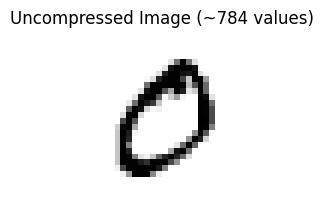

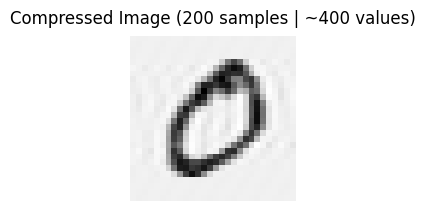

In [195]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Uncompressed Image (~784 values)")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((28,28)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Compressed Image (200 samples | ~400 values)")
plt.show()

Wow, look at this. It actually predicts quite well for mnist digits. Let's use a more complex image and see how it fares. I'm using the cifar10 image dataset to give it a real test. 

In [196]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
targetimage = train_images[1]
targetimage = np.mean(targetimage, axis=2, keepdims=True)

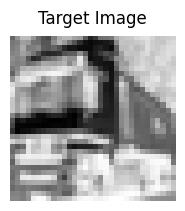

In [197]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((32, 32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

This image is much more intricate that the simple digits we have been dealing with. Let's test it now. 

In [198]:
targetimage = feature_scale(targetimage, scaled=True)
targetimage = targetimage.flatten().astype(np.float64)

pixels = len(targetimage)
xcoordinates = np.linspace(0, 1, pixels).astype(np.float64).reshape((-1, 1))

In [199]:
samples = 190
xcoordinates_wave = feature_engineer_wave(xcoordinates, samples)
print(xcoordinates_wave.shape)

(1024, 381)


In [200]:
reg = LinearRegression().fit(xcoordinates_wave, targetimage)
predicted_image = reg.predict(xcoordinates_wave)
print(reg.coef_.shape)

(381,)


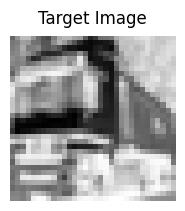

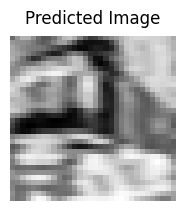

In [201]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Predicted Image")
plt.show()

After some fiddling around, I found that 280 samples works well for this truck image. This is around ~71% of the original data which is pretty good for only linear regression. We can also display the original sine data along with the predicted function to see how it compares. 

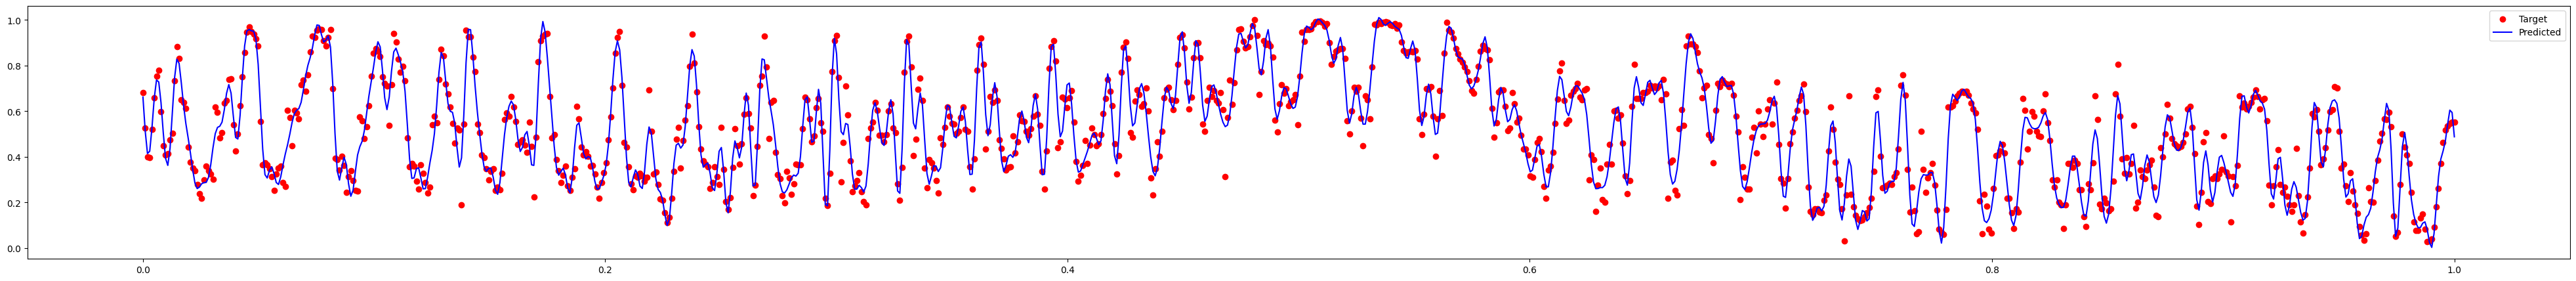

In [202]:
fig,ax = plt.subplots(figsize=(50,5))
ax.scatter(xcoordinates.flatten(), targetimage, color="r",label="Target")
ax.plot(xcoordinates.flatten(), predicted_image, color="b",label="Predicted")
ax.legend()

From this, it looks very accurate and does a good job of understanding the image. All of this is possible from just fourier series features and linear regression which really does surprise me. Now, I also have another idea to try out. Since images tend to be periodic because of close pixel values being similar to each other, as soon as we descend to next row of image, the periodic value is disrupted and we get a completely different value which is likely not similar to the previous value. Normally this isn't an issue, but if we can achieve a lower amount of samples by fixing this, then we should try to do so. In order to fix this issue, one obvious idea is to flip the odd rows or even rows so that the periodic nature still stays the same across the rows. Let's do this!

In [203]:
def flip_odd_matrix(mat): # assumes the matrix rows as even
    oe = np.array([0,1])

    n = mat.shape[0]
    m = mat.shape[1]

    t = np.tile(oe, n//2)
    t = np.repeat(t, m)

    l = t.reshape((n, m))

    flipmat = np.fliplr(mat) # horizontal flip

    tmat = mat * l + flipmat * (1 - l) # lerp to choose the respective row to flip

    return tmat

In [204]:
targetimageflip = flip_odd_matrix(targetimage.reshape((32,32))) # flip the original image and display it
targetimage = flip_odd_matrix(targetimageflip.reshape((32,32))) # re-flip for comparison

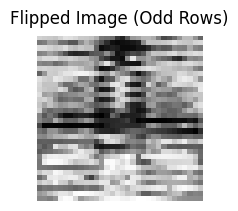

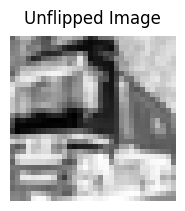

In [205]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimageflip.reshape((32, 32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Flipped Image (Odd Rows)")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Unflipped Image")
plt.show()

Here is the flipped image and the unflipped image to make sure it's actually correct. With this information, let's look at the graph in points for this new flipped image. 

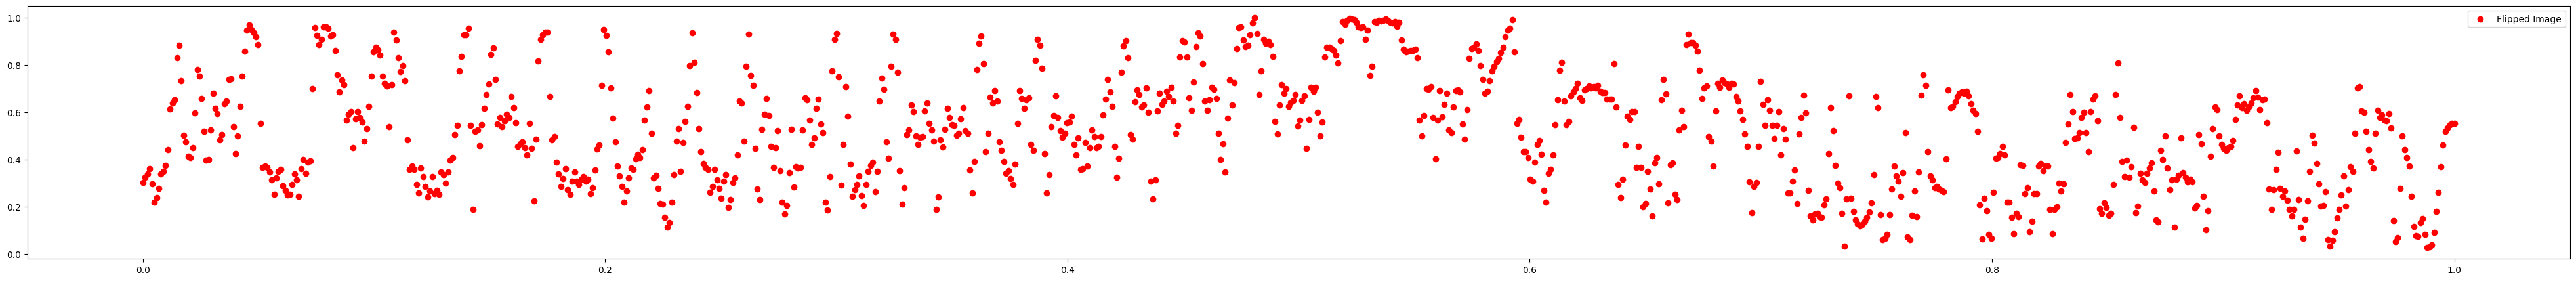

In [206]:
fig,ax = plt.subplots(figsize=(50,5))
ax.scatter(xcoordinates.flatten(), targetimageflip, color="r",label="Flipped Image")
ax.legend()

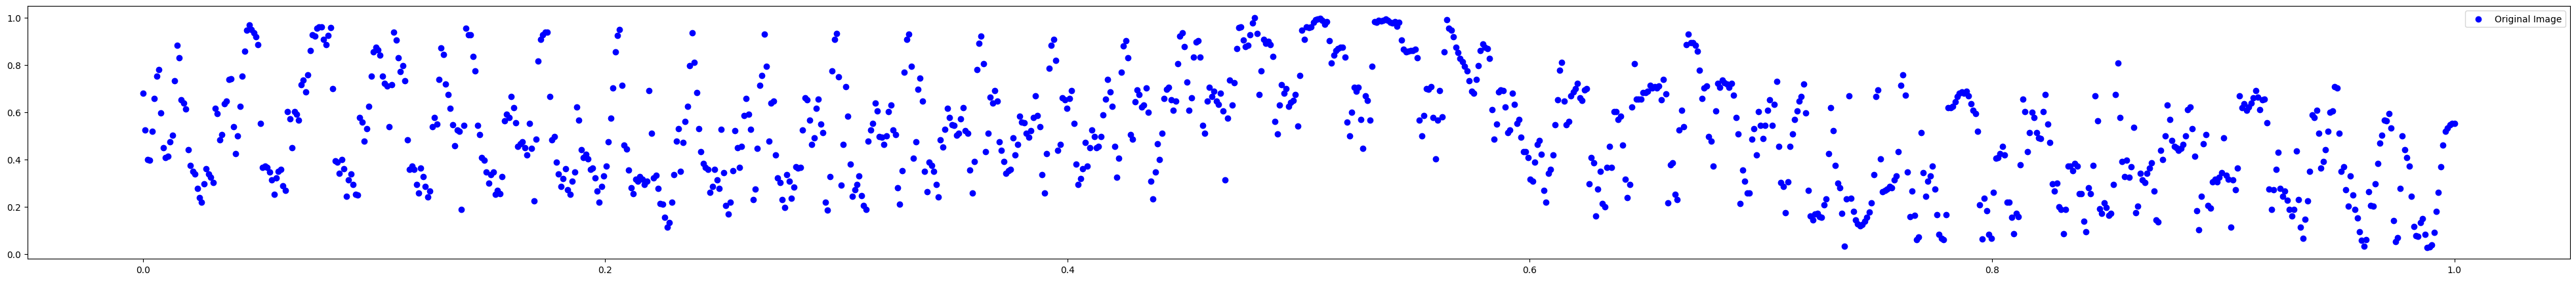

In [207]:
fig,ax = plt.subplots(figsize=(50,5))
ax.scatter(xcoordinates.flatten(), targetimage, color="b",label="Original Image")
ax.legend()

Very interesting, from this it looks like both are very similar so let's actually test it and see how it performs. 

In [208]:
xcoordinates_wave = feature_engineer_wave(xcoordinates, samples)
targetimageflip = targetimageflip.flatten().astype(np.float64)

reg = LinearRegression().fit(xcoordinates_wave, targetimageflip)
predicted_flip_image = reg.predict(xcoordinates_wave)
predicted_image_unflip = flip_odd_matrix(predicted_flip_image.reshape((32,32)))
print(reg.coef_.shape)

(381,)


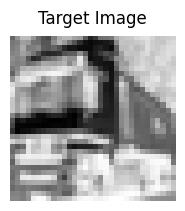

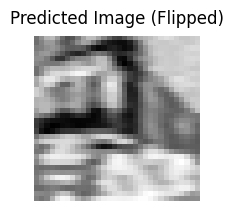

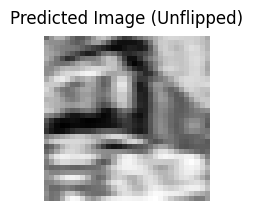

In [209]:
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(targetimage.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image_unflip.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Predicted Image (Flipped)")
plt.show()

fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(predicted_image.reshape((32,32)), interpolation='none', cmap=cm.Greys)
ax.axis('off')
plt.suptitle(f"Predicted Image (Unflipped)")
plt.show()

From this, it looks like flipping it gives marginal returns on benefits. It's not really worth it to flip the image rows it turns out for this particular case. More testing needs to be done, but I do believe that flipping doesn't really help that much for us. Anyways, it was just a thought experiment I had to try out. Next, let's visualize different values of samples to see how the predicted image looks like. 

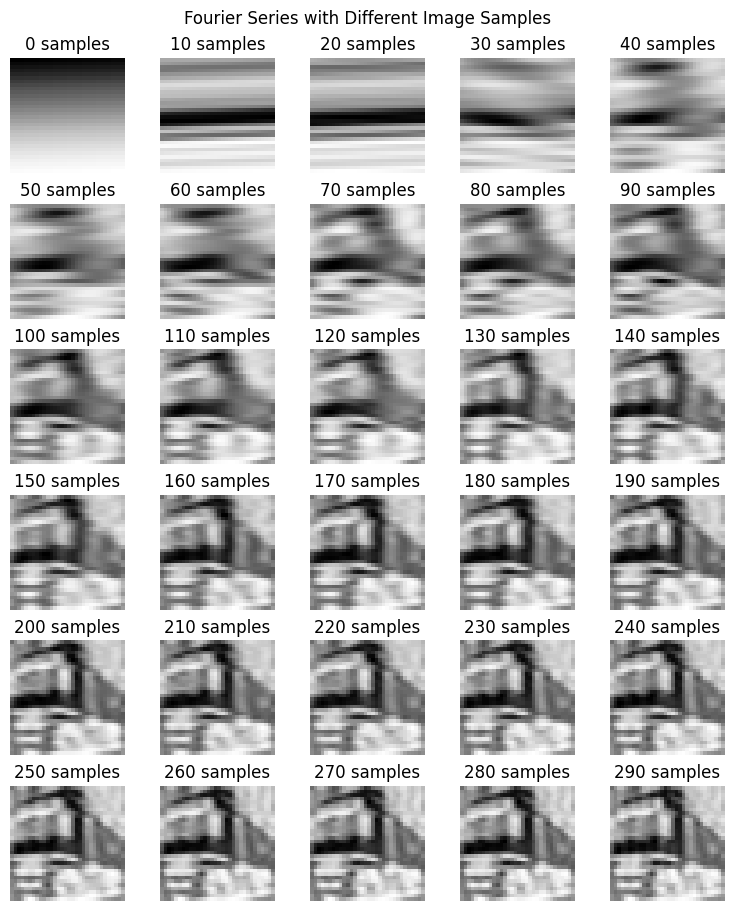

In [210]:
wsize = 5
hsize = 6
fig, axes = plt.subplots(hsize,wsize,figsize=(5*1.5,6*1.5),layout="constrained")
targetimage = targetimage.flatten().astype(np.float64)

for i in range(hsize):
    for j in range(wsize):
        sample = (i*wsize+j)*10 # every 10th sample
        xcoordinates_wave = feature_engineer_wave(xcoordinates, sample)

        reg = LinearRegression().fit(xcoordinates_wave, targetimage)
        predicted_image = reg.predict(xcoordinates_wave)

        axes[i][j].imshow(predicted_image.reshape((32,32)), interpolation='none', cmap=cm.Greys)
        axes[i][j].set_title(f"{sample} samples")
        axes[i][j].axis('off')
plt.suptitle(f"Fourier Series with Different Image Samples")
plt.show()

This is really cool to see. We can get a lot from this visualization. For the amount of samples to choose, it looks like any more than 200 samples will get us marginal benefits so we can safely choose this value as the number of samples for this specific image. Of course, different images have different requirements on the samples. There are also automated ways to figuring out which sample values work best by comparing with the original image. I am choosing to ignore this as this is another rabbit hole to easily get lost in. 

A major issue with this approach. For this test, I only chose $32$ x $32$ images as any higher dimensional images will explode the matrix size. Specifically, using fourier series like this works good but it also is really slow on the order of $O(n^2)$, where $n$ is the total number of pixels, so clearly a high dimensional image will take forever. For these kinds of images, we need an actual neural network or other approaches like the FFT is a good idea as the FFT has a much better complexity of $O(n \log(n))$. These issues are expected since we're only using linear regression but it's still very surprising and impressive to only use regression with fourier series and still achieve some nice cheap compression. And we get to learn about things like the fourier series and why it's very useful for many situations. 

(32, 32, 3)


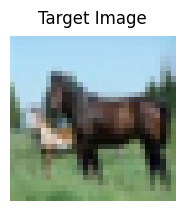

In [211]:
target_image_color = train_images[12]
print(target_image_color.shape)
fig, ax = plt.subplots(figsize=(2,2),layout="constrained")

ax.imshow(target_image_color.reshape((32,32,3)), interpolation='none')
ax.axis('off')
plt.suptitle(f"Target Image")
plt.show()

Let's now look at different color images and try to compress them. The core idea is simple. We simply just do the compression per each R, G, B channel separately and then combine them later during de-compression. Let's also visualize the different color channels. 

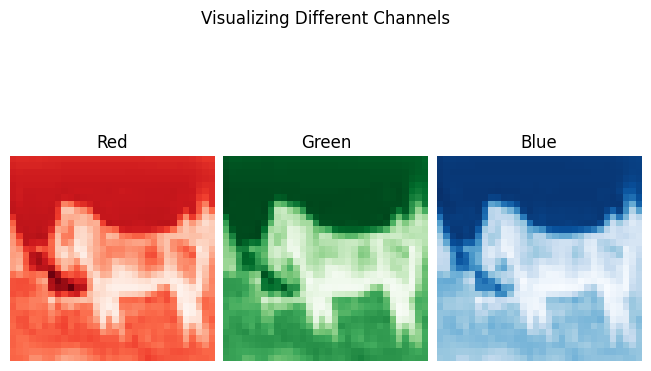

In [212]:
fig, axes = plt.subplots(1,3,layout="constrained")

red_target = target_image_color[:,:,0]
green_target = target_image_color[:,:,1]
blue_target = target_image_color[:,:,2]

axes[0].imshow(red_target, interpolation='none', cmap=cm.Reds)
axes[1].imshow(green_target, interpolation='none', cmap=cm.Greens)
axes[2].imshow(blue_target, interpolation='none', cmap=cm.Blues)

axes[0].set_title("Red")
axes[1].set_title("Green")
axes[2].set_title("Blue")

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

plt.suptitle(f"Visualizing Different Channels")
plt.show()

In [213]:
red_target = feature_scale(red_target, scaled=True).flatten().astype(np.float64)
green_target = feature_scale(green_target, scaled=True).flatten().astype(np.float64)
blue_target = feature_scale(blue_target, scaled=True).flatten().astype(np.float64)

target_image_color = feature_scale(target_image_color, scaled=True)

In [214]:
samples = 190
xcoordinates_wave = feature_engineer_wave(xcoordinates, samples)
print(xcoordinates_wave.shape)

(1024, 381)


In [215]:
red_model = LinearRegression().fit(xcoordinates_wave, red_target)
green_model = LinearRegression().fit(xcoordinates_wave, green_target)
blue_model = LinearRegression().fit(xcoordinates_wave, blue_target)

print(red_model.coef_.shape)
print(green_model.coef_.shape)
print(blue_model.coef_.shape)

red_predict = red_model.predict(xcoordinates_wave).reshape((32,32))
green_predict = green_model.predict(xcoordinates_wave).reshape((32,32))
blue_predict = blue_model.predict(xcoordinates_wave).reshape((32,32))

# now to combine these channels
predicted_image_color = np.dstack([red_predict,green_predict,blue_predict])
predicted_image_color = np.clip(predicted_image_color, 0.0, 1.0)
print(predicted_image_color.shape)

(381,)
(381,)
(381,)
(32, 32, 3)


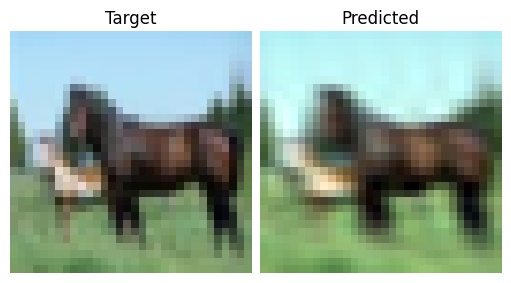

In [216]:
fig, axes = plt.subplots(1,2,figsize=(5,5),layout="constrained")

axes[0].imshow(target_image_color, interpolation='none', cmap=cm.Reds)
axes[1].imshow(predicted_image_color, interpolation='none', cmap=cm.Greens)

axes[0].set_title("Target")
axes[1].set_title("Predicted")

axes[0].axis("off")
axes[1].axis("off")

plt.show()

Make sure to clip the values to 0 and 1 to avoid warnings from matplotlib. Definitely looks great with colors as well. I am curious to see how the colors look during different samples just like the greyscale ones we tried. Let's look at them next. 

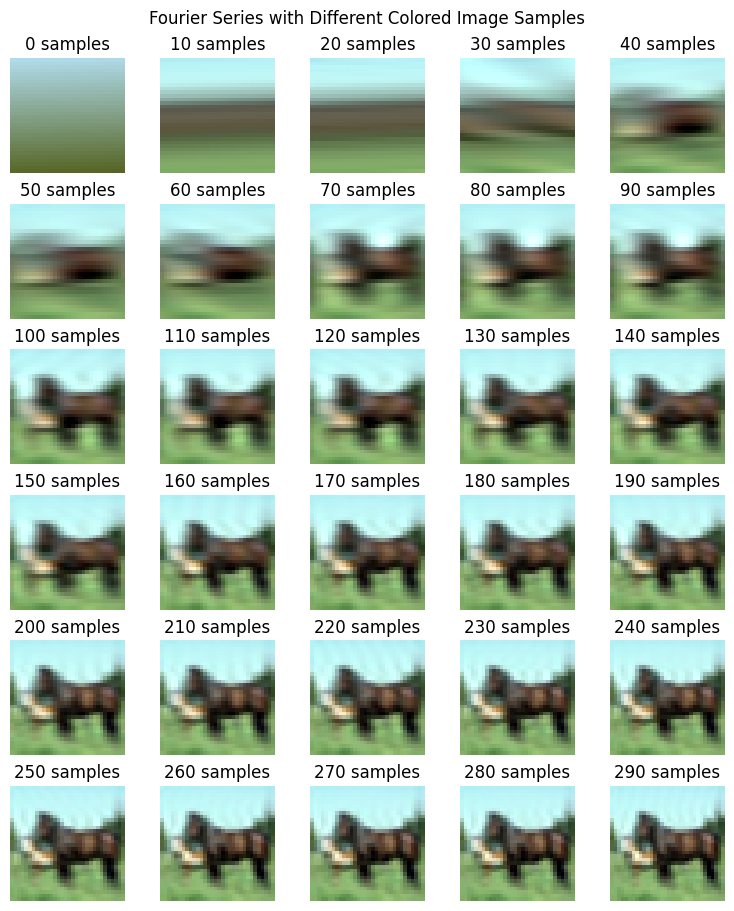

In [217]:
wsize = 5
hsize = 6
fig, axes = plt.subplots(hsize,wsize,figsize=(5*1.5,6*1.5),layout="constrained")

for i in range(hsize):
    for j in range(wsize):
        sample = (i*wsize+j)*10 # every 10th sample
        xcoordinates_wave = feature_engineer_wave(xcoordinates, sample)

        red_model = LinearRegression().fit(xcoordinates_wave, red_target)
        green_model = LinearRegression().fit(xcoordinates_wave, green_target)
        blue_model = LinearRegression().fit(xcoordinates_wave, blue_target)

        red_predict = red_model.predict(xcoordinates_wave).reshape((32,32))
        green_predict = green_model.predict(xcoordinates_wave).reshape((32,32))
        blue_predict = blue_model.predict(xcoordinates_wave).reshape((32,32))

        predicted_image_color = np.dstack([red_predict,green_predict,blue_predict])
        predicted_image_color = np.clip(predicted_image_color, 0.0, 1.0)

        axes[i][j].imshow(predicted_image_color, interpolation='none')
        axes[i][j].set_title(f"{sample} samples")
        axes[i][j].axis('off')
plt.suptitle(f"Fourier Series with Different Colored Image Samples")
plt.show()

Wow, look at that. Looks very nice. Color isn't much of an issue once you get greyscale figured out as it's just different channels. Since it's hard to know what's the right sample count to choose, let's look at differences between the actual image to get a sense of when it's enough samples.

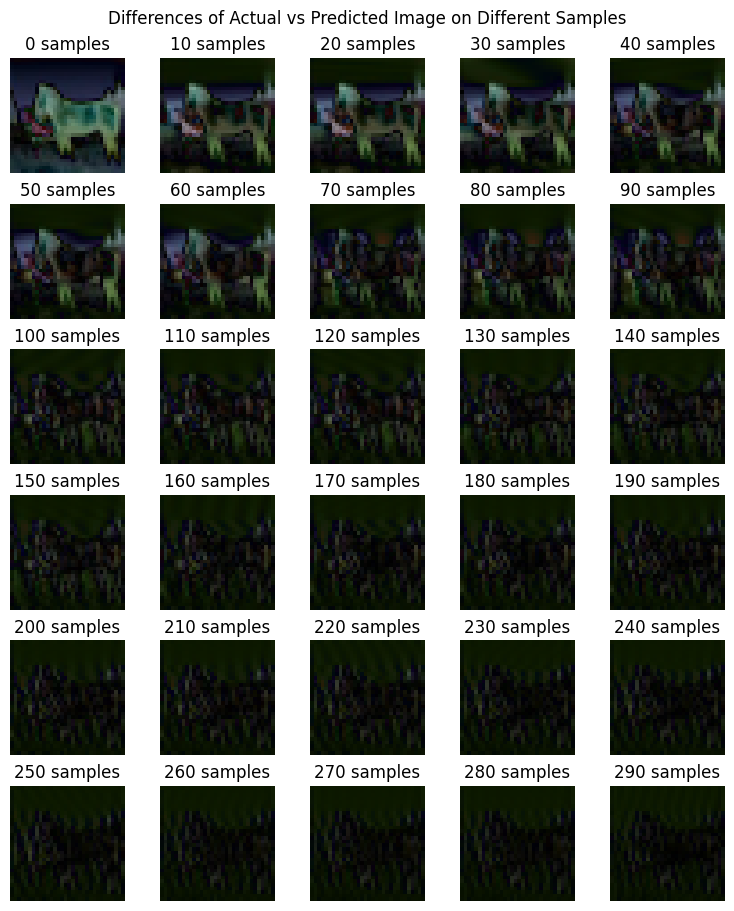

In [218]:
wsize = 5
hsize = 6
fig, axes = plt.subplots(hsize,wsize,figsize=(5*1.5,6*1.5),layout="constrained")

for i in range(hsize):
    for j in range(wsize):
        sample = (i*wsize+j)*10 # every 10th sample
        xcoordinates_wave = feature_engineer_wave(xcoordinates, sample)

        red_model = LinearRegression().fit(xcoordinates_wave, red_target)
        green_model = LinearRegression().fit(xcoordinates_wave, green_target)
        blue_model = LinearRegression().fit(xcoordinates_wave, blue_target)

        red_predict = red_model.predict(xcoordinates_wave).reshape((32,32))
        green_predict = green_model.predict(xcoordinates_wave).reshape((32,32))
        blue_predict = blue_model.predict(xcoordinates_wave).reshape((32,32))

        predicted_image_color = np.dstack([red_predict,green_predict,blue_predict])
        predicted_image_color = np.clip(predicted_image_color, 0.0, 1.0)

        difference_image = np.abs(target_image_color - predicted_image_color)
        difference_image = np.clip(difference_image, 0.0, 1.0)

        axes[i][j].imshow(difference_image, interpolation='none')
        axes[i][j].set_title(f"{sample} samples")
        axes[i][j].axis('off')
plt.suptitle(f"Differences of Actual vs Predicted Image on Different Samples")
plt.show()

So it's very pronounced at lower samples but at higher samples the differences don't account to much. It's really interesting to see otherwise. There are many other approaches we haven't explored such as bigger images or FFT or even neural nets. We also didn't use any hyperparameter tuning of the samples size to figure out the best sample given our constraints on accuracy vs speed. We also didn't quantify how bad the accuracy for different samples. There are so many ways to take this further and show something interesting.